In [14]:
import pandas as pd
import re
import os

def check_bin_number():
    range_file = "range.txt"
    num_bin = 0
    if os.path.exists(range_file):
        with open(range_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                # seperate it by whitespace
                parts = line.strip().split()
                if len(parts)==1:
                    num_bin = int(parts[0])
                    break
    else:
        print(f"File {range_file} does not exist. Please create it with the number of bins.")
        exit(1)
    return num_bin


def check_seq_length(num_bin):
    # check if we have a file named "bin_0.txt", "bin_1.txt", ..., "bin_n.txt"
    seq_folder = 'sequentialized_data'
    for bin_id in range(0, num_bin):
        file_name = os.path.join(seq_folder, f'bin_{bin_id}.csv')
        if not os.path.exists(file_name):
            print(f"File {file_name} does not exist. Please create it.")
            exit(1)
    return True


In [15]:
num_bin = check_bin_number()
print(f'Number of bins: {num_bin}')
if not check_seq_length(num_bin):
    print("Sequence length check failed.")
    exit(1)
else:
    print(f"All {num_bin} files exist. Proceeding with processing...")

Number of bins: 200
All 200 files exist. Proceeding with processing...


## target format
"process_1": {
        "pid": 1,
        "tasks": [
            {
                "task_id": "0",
                "task_name": "P1_T0_seq_write",
                "op": "seq_write",
                "task_from": 0,
                "task_range": 97,
                "content": "The first story is about connecting the dots. I dropped out ofate student, and she deciexpensive "
            },
            {
                "task_id": "1",
                "task_name": "P1_T1_seq_write",
                "op": "seq_write",
                "task_from": 97,
                "task_range": 22,
                "content": "as Stanford, and all o"
            }
        ]
    },

In [16]:
mp = {}
overwrites = []
seq_writes = []
def insert_dummy(task_range):
    # insert dummy data for task_range
    if task_range == 0:
        return '0'
    else:
        # just return a string of '0's with length task_range
        return '0' * task_range

def process_bin(bin_id):
    file_name = os.path.join('sequentialized_data', f'bin_{bin_id}.csv')
    df = pd.read_csv(file_name, header=None)
    # remove the first row for it is just a header
    df = df.iloc[1:]
    process_name = f'process_{bin_id}'
    pid = bin_id
    task_id = 0
    process_tasks = []
    # iterate through the rows and add task_id, task_name, op, task_from, task_range, content
    # for row, data in df.iterrows():
    #     data = data.strip(',')
    #     per_task_id = str(task_id)
    for idx, row in df.iterrows():
        row = row.apply(lambda x: x.strip(',') if isinstance(x, str) else x)
        per_task_id = str(task_id)  # ensure task_id is defined
        per_task_op = str(row[0])
        per_task_from = int(row[1])
        per_task_range = int(row[2])
        per_task_content = insert_dummy(per_task_range)
        task = {
            'task_id': per_task_id,
            'task_name': f'task_{per_task_id}',
            'op': per_task_op,
            'task_from': per_task_from,
            'task_range': per_task_range,
            'content': per_task_content
        }
        task_id += 1
        process_tasks.append(task)
        if task['op'] == 'overwrite':
            overwrites.append(task['task_range'])
        elif task['op'] == 'seq_write':
            seq_writes.append(task['task_range'])
    return process_name, pid, process_tasks

for i in range(0, num_bin):
    process_name, pid, process_tasks = process_bin(i)
    print(i)
    if len(process_tasks) == 0: 
        continue

    mp[process_name] = {
        "pid": pid,
        "tasks": process_tasks
    }
print(len(mp))
# dump the mp into a json file
import json
output_file = 'process_map.json'
with open(output_file, 'w') as f:
    json.dump(mp, f, indent=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
5


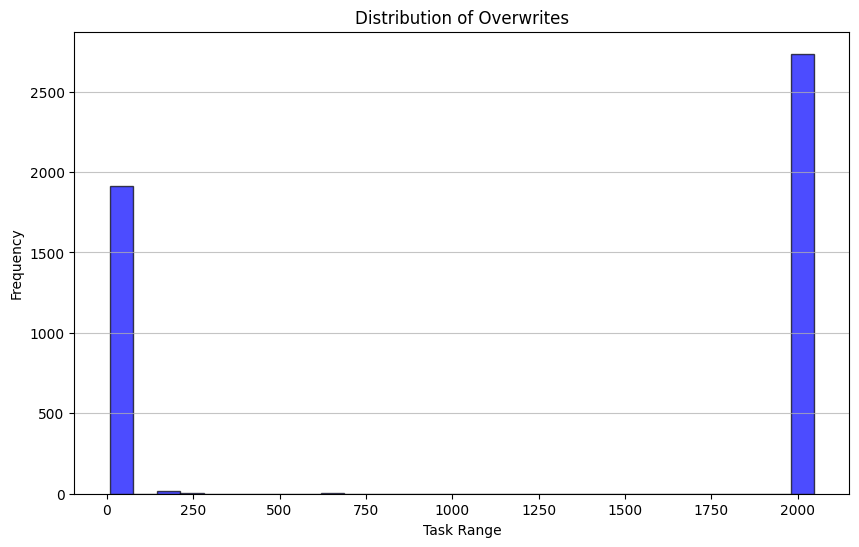

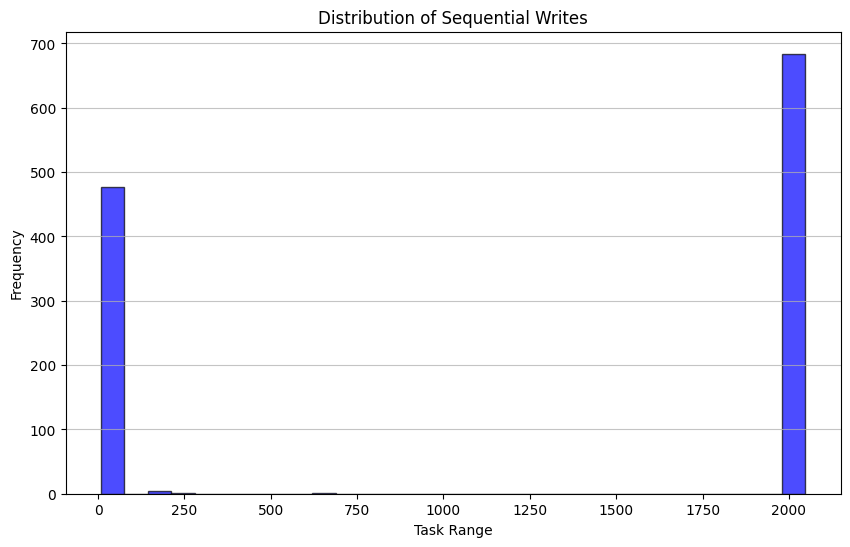

5625672
1406408
Unique overwrites: 9 {2048, 160, 672, 8, 168, 264, 16, 176, 152}


In [17]:
# analyze the overwrites and seq_writes by plot its distribution
import matplotlib.pyplot as plt
import numpy as np
def plot_distribution(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.75)
    plt.show()
plot_distribution(overwrites, 'Distribution of Overwrites', 'Task Range', 'Frequency')
plot_distribution(seq_writes, 'Distribution of Sequential Writes', 'Task Range', 'Frequency')
print(sum(overwrites))
print(sum(seq_writes))
unique_overwrites = set(overwrites)
print(f'Unique overwrites: {len(unique_overwrites)}', unique_overwrites)


In [18]:
# recommand space:
print(f"Total number of processes: {len(mp)}")
print(f"Total number of overwrites: {len(overwrites)}", " and its total size:", sum(overwrites))
print(f"Total number of sequential writes: {len(seq_writes)}", " and its total size:", sum(seq_writes))
print("we need at least this much space for overwrites and sequential writes:", sum(overwrites) + sum(seq_writes))

Total number of processes: 5
Total number of overwrites: 4677  and its total size: 5625672
Total number of sequential writes: 1168  and its total size: 1406408
we need at least this much space for overwrites and sequential writes: 7032080
